# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [79]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

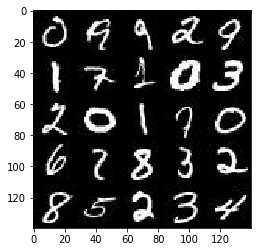

In [80]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

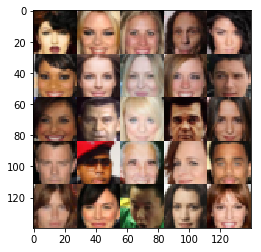

In [81]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [83]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')

    return input_real, input_z, learn_rate




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [84]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [85]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
       
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.5)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
              
        flat = tf.reshape(x3, (-1, 4096))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [86]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
   
    with tf.variable_scope('generator', reuse = not is_train):
        
        x1 = tf.reshape(tf.layers.dense(z, 4*4*256), (-1,4,4,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1, 0.90)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2, 0.90)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3, 0.90)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='valid')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [87]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #added smoothing parameter as suggested by reviwer:
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*.9))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [88]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [89]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [90]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_z = np.random.uniform(-1, 1, size = [batch_size, z_dim])
                
                # Compensate for tanh [-1,1] x RGB [-.5,.5] range disparity, as required by reviewer
                if data_image_mode == 'RGB':
                    batch_images *= 2.0
                    
                feed_dict = {input_real: batch_images,
                             input_z: batch_z,
                             learn_rate: learning_rate}
                _ = sess.run(d_opt, feed_dict = feed_dict)
                _ = sess.run(g_opt, feed_dict = feed_dict)
                _ = sess.run(g_opt, feed_dict = feed_dict) # as suggested by reviewer
                _ = sess.run(g_opt, feed_dict = feed_dict) # as suggested by reviewer
                
                if i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    if i % 100 == 0:
                        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7274... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 2.1407... Generator Loss: 1.0278
Epoch 1/2... Discriminator Loss: 1.9681... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.7887... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.8544... Generator Loss: 0.8272
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 1.8720... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.8213... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.3692


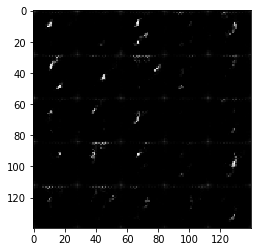

Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.0864... Generator Loss: 1.4537
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 2.4730
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 2.3216
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 2.7802
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 3.7716
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 1.7934
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.6953
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.1340


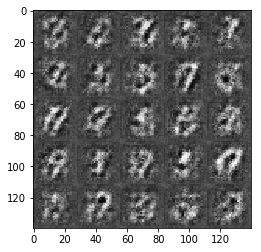

Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 1.8258
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.7718
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 1.7732
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 1.4956
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 1.7312
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 1.9363


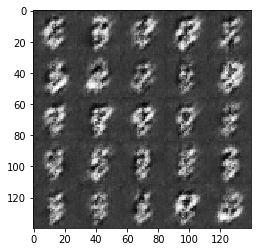

Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 1.6017
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 2.0141
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 1.7112
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 1.7671
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 1.5494
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.5634
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 1.6531


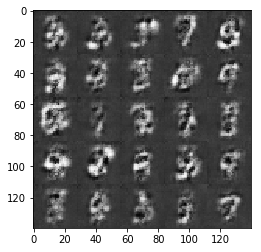

Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.8331
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 1.5044
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.4217


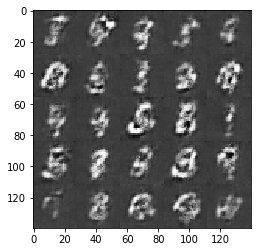

Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.3637
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 1.2279
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 1.1110
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.4007... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.3326


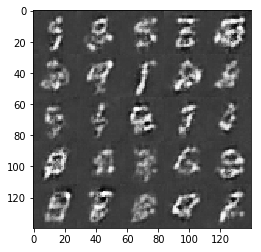

Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.6956
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 1.7556
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.3658
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 1.2621


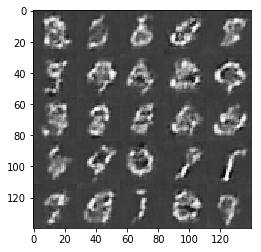

Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 1.8562
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.3046
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 2.2218


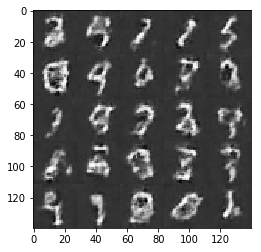

Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 1.9718
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 1.2924
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.1908... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 1.6073
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 1.5021


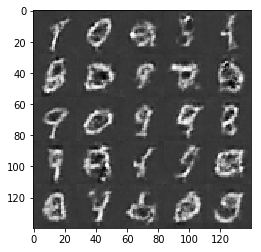

Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 1.8140
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.4924
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 1.4262
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 1.8203
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 1.2487
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 1.2069
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 1.2353
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 1.4118


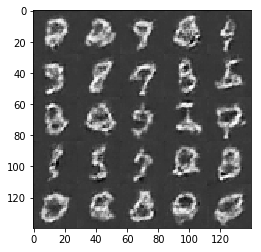

Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 1.3814
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 1.5174
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.2099
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 1.2822


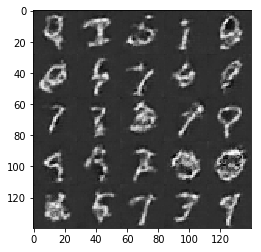

Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.4292
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 1.3583
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 1.4749
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 1.7545
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 1.2708


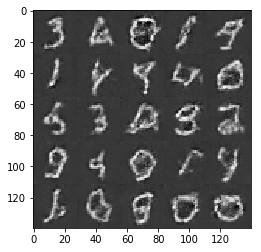

Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 1.4228
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 1.3071
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.0457
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.9616


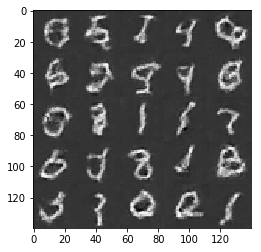

Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 1.3050
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 1.1283
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 1.6100
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 1.5471
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 1.6093


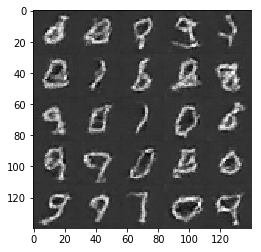

Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.3211
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 1.1238
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 1.4870
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.2087
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.5396


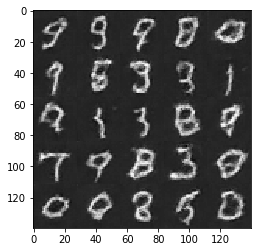

Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 1.6039
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.4464
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 1.7957
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 1.4881
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 1.1200
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 1.4333
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 1.3851


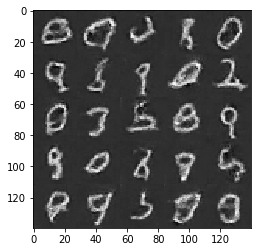

Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.2159
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 1.3897
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.2590
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.9390
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 1.4625
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.6781


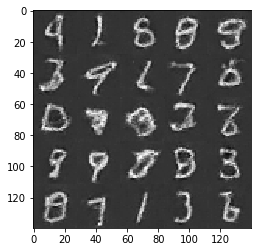

Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 1.4868
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 1.6420
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 1.2339
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 1.2699


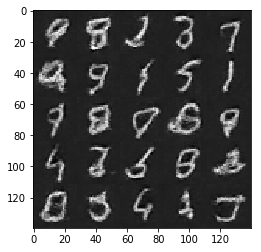

Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 1.2048
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 1.4384
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 1.5427
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.6211


In [91]:
batch_size = 64
z_dim = 128
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 2.3743
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.8062


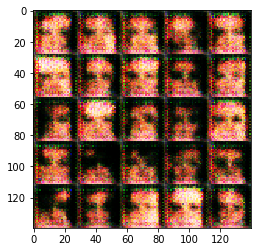

Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.8851
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 1.8642
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 2.1296
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 2.2578


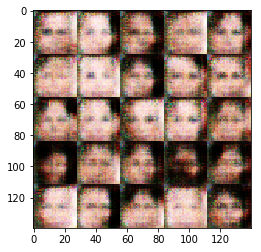

Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 2.1106
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.2908


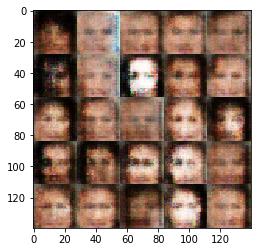

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.8651... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.7665... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 1.1315


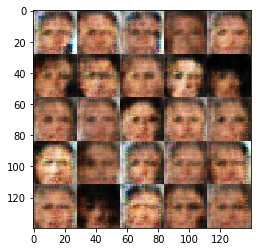

Epoch 1/1... Discriminator Loss: 1.8650... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 1.0322


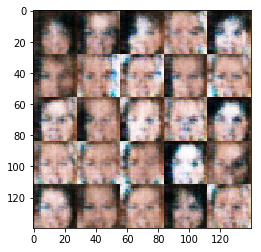

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8702


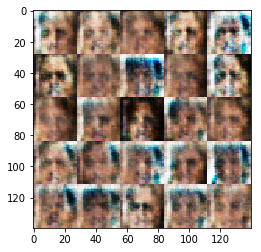

Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.0320


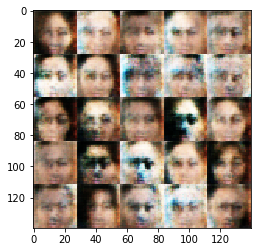

Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 1.0008


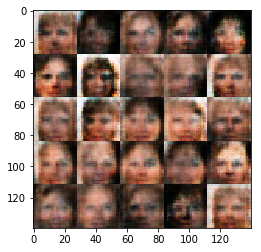

Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.8344


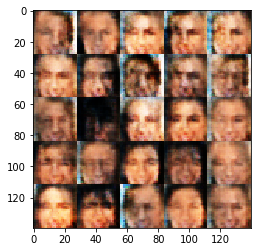

Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8611


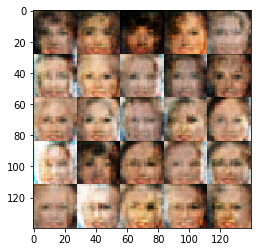

Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7565


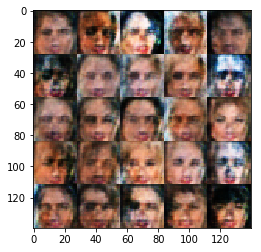

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7511


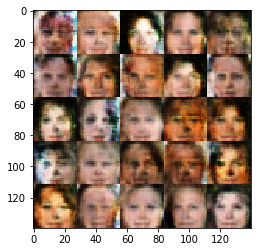

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8921


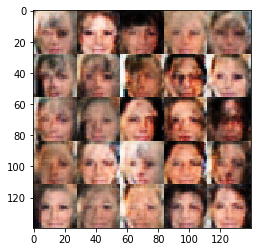

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7794


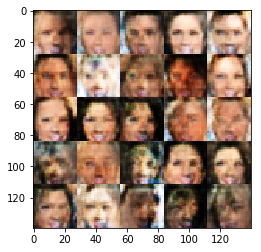

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7568


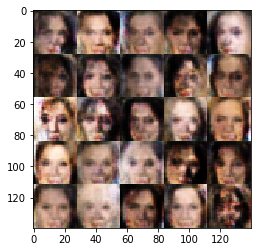

Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.7974


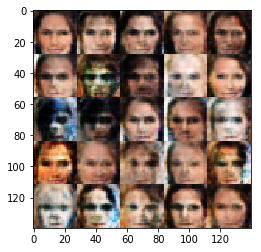

Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8989


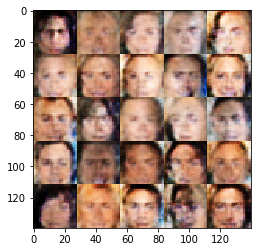

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8114


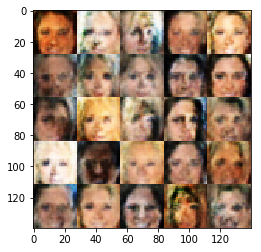

Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8774


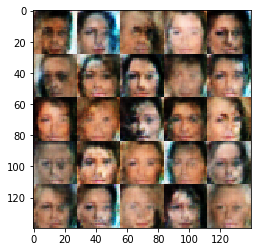

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8379


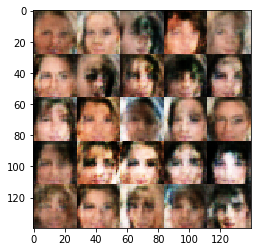

Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7777


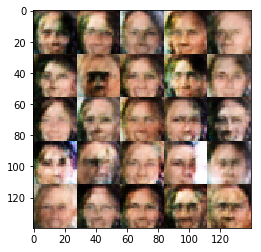

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8359


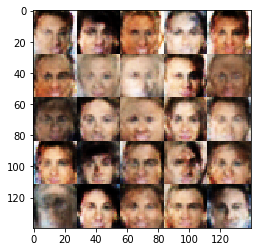

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8254


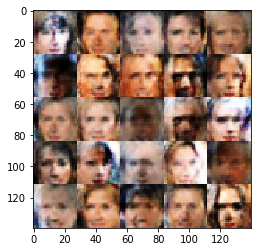

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8385


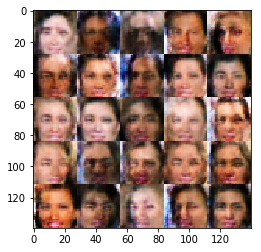

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7729


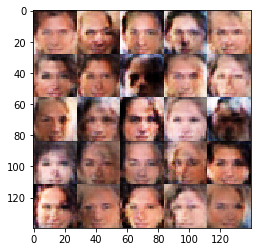

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8237


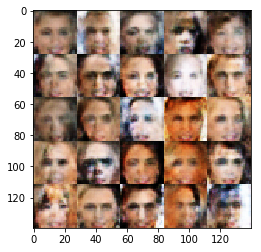

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7852


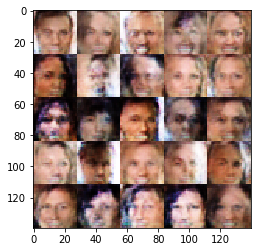

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8271


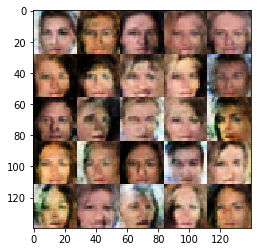

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7516


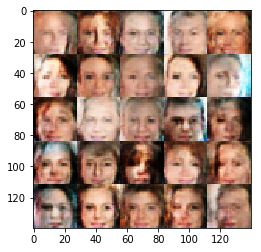

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.8103


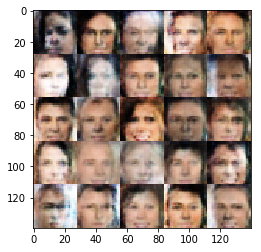

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7089


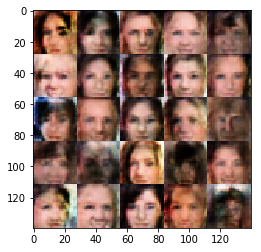

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7323


In [92]:
batch_size = 64
z_dim = 128
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.